# Comments

In [57]:
# It should take less than about 30 s to run the
# entire notebook under the default settings.

# Import appropriate packages and set analysis options.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
import seaborn as sns
sns.set(color_codes=True)
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from IPython.core.interactiveshell import InteractiveShell
from math import sqrt
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Setting save_predicted_data to True
# will cause the notebook to save data
# in one of the last notebook cells.
# The data will be saved to the path
# specified by MY_PREDICTED_DATA_PATH.
save_predicted_data = False

# As expected, setting print_all_output
# to True will cause each evaluation in a
# a cell to be displayed. This has the
# unfortunate side-effect of preventing the
# ';' operator from silencing output.
# If this boolean is set to False, then
# only the last item in each cell may
# be output.
print_all_output = False
InteractiveShell.ast_node_interactivity = 'all' if print_all_output else 'last_expr'

# Setting randomize_seeding to True will
# randomize various operations throughout
# the notebook. Setting it to False will
# cause the seed to remain fixed to some
# specified value such that the notebook
# can be reran with the same randomized
# variables (see MAGIC_SEED below).
randomize_seeding = False

# Define convenient variables and functions.

In [30]:
# These paths indicate from where the training,
# test, and prediction data will be loaded/saved.
TRAINING_DATA_PATH = "./data/train.csv"
TEST_DATA_PATH = "./data/test.csv"
MY_PREDICTED_DATA_PATH = "./data/my_predicted_survivors.csv"

# The MAGIC_SEED optionally specifies a fixed
# random state/seed so that the notebook can be
# reran with the same randomized variables (see
# randomize_seeding above).
MAGIC_SEED = 1776
if (randomize_seeding):
    MAGIC_SEED = np.random.seed()

# The training data provided with this data
# set will be split into two subsets so that
# models can be trained on the first and tested
# on the second. TRAINING_DATA_TEST_SIZE
# indicates the proportion of the training
# data that will be used as test data for
# model evaluation and should be in the
# range [0.0, 1.0].
TRAINING_DATA_TEST_SIZE = 0.10

def load_data(path, index_column):
    """
    Load the file at 'path' into a Pandas
    DataFrame.
    """
    df = pd.read_csv(path, header=0, index_col=index_column)
    print("Loaded data dimensions: ", df.shape[0], "rows, ", df.shape[1], "columns")
    return df

def print_nan(nan_cols_counts, col_type):
    """
    Print each element of the list which should contain
    a DataFrame feature name and an int number of times
    the feature contains an NaN value.
    """
    print("\n", len(nan_cols_counts), " ", col_type, "-type columns with NaN values.", sep='')
    if(len(nan_cols_counts) > 0):
        print("    {:<16}{}".format("Feature", "NaN Count"))
        print("%s" % "    ---------------------")
    for index, element in enumerate(nan_cols_counts):
        print("{:>2}. {:<16}{}".format(index+1, element[0], element[1]))
        
def gather_nan(df, col_type, print_if_nan = True):
    """
    Find all DataFrame columns of type 'col_type'
    which contain NaN values.
    """
    if (col_type == "int"):
        columns = df.select_dtypes(include=['int']).columns
    elif (col_type == "float"):
        columns = df.select_dtypes(include=['float']).columns
    else:
        columns = df.select_dtypes(include=['object']).columns
    nan_cols_counts = []
    for col in np.sort(columns):
        num_nan = np.sum(df[col].isnull())
        if (num_nan > 0):
            nan_cols_counts.append((col, num_nan))
    if (print_nan):
        print_nan(nan_cols_counts, col_type)
    return nan_cols_counts
            
def replace_with_normal(df, col, seed = np.random.seed()):
    """
    Replace NaN values in a DataFrame column with
    values chosen from a normal distribution with
    a mean and standard deviation equal to the
    that of the non-NaN data.
    """
    np.random.seed(seed)
    df_dropped = df[col].dropna()
    mu = np.mean(df_dropped)
    sigma = np.std(df_dropped)
    null_rows = df[col].isnull()
    num_nan = np.sum(null_rows)
    rand_vals = np.random.normal(mu, sigma, num_nan)
    df.loc[null_rows, col] = rand_vals
    
def most_common_label(df, col):
    """
    Determine the most fequent label for
    categorical data.
    """
    most_common_appearances = 0
    most_common_label = ""
    for label in df[col].unique():
        num_appearances = np.sum(df[col] == label)
        if (num_appearances > most_common_appearances):
            most_common_appearances = num_appearances
            most_common_label = label
    return most_common_label

def evaluate_model(x_train, y_train, model):
    """
    Given an input model and training data,
    split the data into training/testing subsets
    and use this to produce a fit and predictions.
    Indicate the goodness of the fit and plot
    the results.
    """
    # Split the training data into two subsets.
    # Then, train the model on the target data
    # and use it to predict home prices.
    x_train1, x_train2, y_train1, y_train2 = train_test_split(
        x_train, y_train,
        test_size=TRAINING_DATA_TEST_SIZE,
        random_state=MAGIC_SEED)
    model.fit(x_train1, y_train1)
    y_train2_pred = model.predict(x_train2)
    
    # Evaluate the model & predictions by viewing
    # the cross-validation score, error, and
    # variance (where a variance of 1 indicates
    # a perfect prediction) and plotting the results.
    print("When using %0.1f%% of the training data to perform the"
        " fit and %0.1f%% of the training data to make the prediction,"
        " the model performed according to the following:"
        % (100.0*(1.0-TRAINING_DATA_TEST_SIZE), 100.0*TRAINING_DATA_TEST_SIZE))
    print(cross_val_score(model, x_train1, y_train1, cv=5))
    print("RMS Error: %.3f"
        % sqrt(mean_squared_error(y_train2, y_train2_pred)))
    print('Variance score: %.3f' % r2_score(y_train2, y_train2_pred))
#    plt.hist(y_train2, bins=2, color='red')
#    plt.hist(y_train2_pred, bins=2, histtype='step', color='black')
    x = np.arange(4)
    y = [y_train2.tolist().count(1), y_train2_pred.tolist().count(1),
         y_train2.tolist().count(0), y_train2_pred.tolist().count(0)]
    colors = ("green", "cyan", "red", "magenta")
    plt.bar(x, y, color=colors)
    plt.xticks(x, ("True Survival", "Pred. Survival",
        "True Decease", "Pred. Decease"))
    plt.show()
    
    # Finalize the model by fitting it to the entire data set.
    model.fit(x_train, y_train)
    
def most_important_features(df, feature_importances, num_features):
    """
    Select and pritn out the N most important features used
    in the model to make predictions.
    """
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1].tolist()
    top_n_indices = sorted_indices[:5]
    print("The %d most important features for this model:" % num_features)
    for ii, index in enumerate(top_n_indices):
        print("%d. %s" % (ii+1, df.columns[index]))

def encode(df):
    """
    Convert categorical labels to ints.
    """
    label_encoder = preprocessing.LabelEncoder()
    encoded_label_groups = []
    for col in df.select_dtypes(include=['object']).columns:
        label_encoder.fit(df[col].unique());
        encoded_label_groups.append(label_encoder.classes_.tolist())
        df.loc[:, col] = label_encoder.transform(df[col]);
    return encoded_label_groups

# Load and preview the passenger training data.

In [31]:
df = load_data(TRAINING_DATA_PATH, 'PassengerId')
df.head()

Loaded data dimensions:  891 rows,  11 columns


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [32]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Clean and process the training data.

In [33]:
# Partition data into features (X-data) and
# targets (Y-data).
x_train = df.iloc[:,1:]
y_train = df.iloc[:,0]

# Determine which features have missing values.
nan_int_cols = gather_nan(x_train, "int")
nan_float_cols = gather_nan(x_train, "float")
nan_string_cols = gather_nan(x_train, "string")


0 int-type columns with NaN values.

1 float-type columns with NaN values.
    Feature         NaN Count
    ---------------------
 1. Age             177

2 string-type columns with NaN values.
    Feature         NaN Count
    ---------------------
 1. Cabin           687
 2. Embarked        2


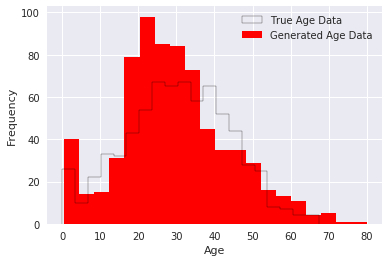

In [34]:
# First, determine how the Age data is distributed.
x_age = x_train['Age'].dropna().tolist()
mu_age = np.mean(x_age)
sigma_age = np.std(x_age)

# Generate age samples using the age data's
# average and standard deviation. Graphically
# compare the real and fabricated data (normalized
# for easy comparison).
x_age_generated = np.random.normal(mu_age, sigma_age, len(x_age))

# Set all ages below zero to zero.
x_age_generated[(x_age_generated <= 0)] = 0
plt.hist(x_age, bins=20, color='red', normed=0)
plt.hist(x_age_generated, bins=20, histtype='step', color='black', normed=0)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(("True Age Data", "Generated Age Data"))
plt.show()

### Visually, the data distributions appear only mildly resemblant. Directly test whether the age data is normal by testing the similarity between the true and fabricated data distributions.

In [35]:
# Test whether these data sets have similar
# distributions using the Kolmogorov-Smirnov
# test. A large p-value (e.g. > 0.05) indicates
# that the distributions are similar enough to
# warrant considering them the same.
stats.ks_2samp(x_age, x_age_generated)

Ks_2sampResult(statistic=0.086834733893557448, pvalue=0.0085438112518194075)

### The Kolmogorov-Smirnov test tends to indicate that the age data is not normally distributed.

In [36]:
# Contrary to the above K-S test, as an approximation, assume
# the age data is normally distributed and replace all NaN
# values with values randomly selected from a normal
# distribution with the same mean and standard deviation
# as the non-NaN value data.
replace_with_normal(x_train, 'Age', MAGIC_SEED)

# Set all ages below zero to zero (a consequence of choosing
# ages from a normal distribution).
x_train.loc[x_train['Age'] < 0, 'Age'] = 0.0

In [37]:
# The 'Cabin' feature is very sparse, so drop
# this feature since it can provide only very
# limited information.
print("Out of %d instances, %d have missing Cabin information; dropping this feature."
      % (df.shape[0], sum(x_train['Cabin'].isna())))
x_train.drop('Cabin', axis='columns', inplace=True)

Out of 891 instances, 687 have missing Cabin information; dropping this feature.


In [38]:
# It seems unlikely that the passenger's name,
# ticket number, or port of embarkation would
# correlate with their survival. Drop these features.
x_train.drop('Name', axis='columns', inplace=True)
x_train.drop('Ticket', axis='columns', inplace=True)
x_train.drop('Embarked', axis='columns', inplace=True)

In [39]:
# Retrieve the categorical column labels.
categorical_features = x_train.select_dtypes(include=['object']).columns.tolist()

# Encode all categorical features.
encoded_label_groups = encode(x_train)
features_and_encoded_labels = list(zip(categorical_features, encoded_label_groups))

In [40]:
# At this point, the DataFrame should be free of
# missing values.
nan_int_cols = gather_nan(x_train, "int")
nan_float_cols = gather_nan(x_train, "float")
nan_string_cols = gather_nan(x_train, "string")
x_train.head()


0 int-type columns with NaN values.

0 float-type columns with NaN values.

0 string-type columns with NaN values.


,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,3,1,22.0,1,0,7.2500
2,1,0,38.0,1,0,71.2833
3,3,0,26.0,0,0,7.9250
4,1,0,35.0,1,0,53.1000
5,3,1,35.0,0,0,8.0500


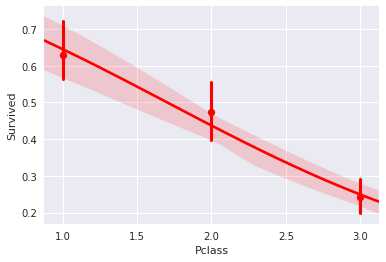

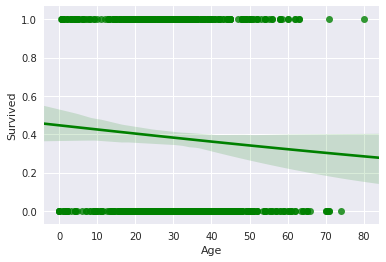

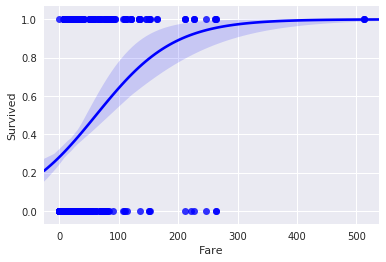

In [41]:
# Plot the survival rate as a function of other features - class
# ("Pclass"), age, and fare - along with a 98% confidence interval
# to get an idea of how various features influence survival.

sns.regplot(x=x_train["Pclass"], y=y_train, n_boot=100,
    logistic=True, ci=98, color='red', x_estimator=np.mean)
plt.show()

sns.regplot(x=x_train["Age"], y=y_train, n_boot=100,
    logistic=True, ci=98, color='green')
plt.show()

sns.regplot(x=x_train["Fare"], y=y_train, n_boot=100,
    logistic=True, ci=98, color='blue')
plt.show()

# Perform hyperparameter tuning for a logistic regression model.

In [42]:
estimator = linear_model.LogisticRegression(random_state=MAGIC_SEED)

## Method #1: Grid Search w/ Cross-Validation

When using 90.0% of the training data to perform the fit and 10.0% of the training data to make the prediction, the model performed according to the following:
[ 0.7826087  0.7875     0.81875    0.80625    0.7875   ]
RMS Error: 0.435
Variance score: 0.238


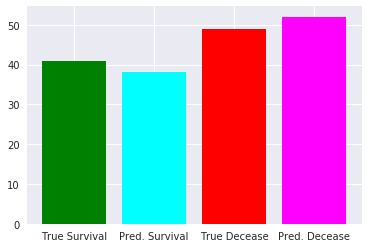

The best parameters are:
{'C': 0.25, 'fit_intercept': True, 'penalty': 'l2', 'tol': 0.0001}
with a score of 0.792


In [43]:
parameter_grid = {
    "penalty": ['l1', 'l2'],
    "tol": [1e-4, 1e-5, 1e-6],
    "C": [0.25, 0.5, 0.75, 1.0],
    "fit_intercept": [True, False]
}
model = GridSearchCV(estimator, cv=5, return_train_score=True,
    param_grid=parameter_grid)
evaluate_model(x_train, y_train, model)
print("The best parameters are:")
print(model.best_params_)
print("with a score of %.3f" % model.best_score_)

# Save the model for later usage.
prediction_model = model

## Method #2: Randomized Search w/ Cross-Validation

When using 90.0% of the training data to perform the fit and 10.0% of the training data to make the prediction, the model performed according to the following:
[ 0.78881988  0.78125     0.81875     0.80625     0.7875    ]
RMS Error: 0.435
Variance score: 0.238


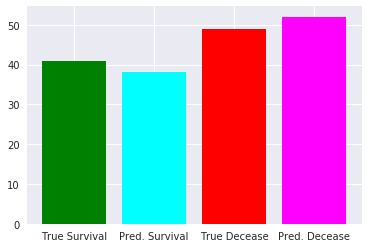

The best parameters are:
{'tol': 3.5999999999999994e-05, 'penalty': 'l2', 'fit_intercept': True, 'C': 0.13}
with a score of 0.790


In [44]:
num_iterations = 25
parameter_distributions = {
    "penalty": ['l1', 'l2'],
    "tol": np.arange(1e-6, 1e-4, 1e-6),
    "C": np.arange(0.1, 1.0, 0.01),
    "fit_intercept": [True, False]
} 
    
model = RandomizedSearchCV(estimator, cv=5, return_train_score=True,
    param_distributions=parameter_distributions, n_iter=num_iterations, 
    random_state=MAGIC_SEED)
evaluate_model(x_train, y_train, model)
print("The best parameters are:")
print(model.best_params_)
print("with a score of %.3f" % model.best_score_)

### The grid and randomized searched seem to return similar results, so arbitrarily use the grid search parameters to make predictions for the passenger data.

# Load and preview the passenger test data.

In [45]:
df = load_data(TEST_DATA_PATH, "PassengerId")
df.head()

Loaded data dimensions:  418 rows,  10 columns


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [46]:
df.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


# Clean and process the test data.

In [47]:
# Since the test data only includes features,
# it is exclusively X-data.
x_test = df

# Determine which features have missing values.
nan_int_cols = gather_nan(x_test, "int")
nan_float_cols = gather_nan(x_test, "float")
nan_string_cols = gather_nan(x_test, "string")


0 int-type columns with NaN values.

2 float-type columns with NaN values.
    Feature         NaN Count
    ---------------------
 1. Age             86
 2. Fare            1

1 string-type columns with NaN values.
    Feature         NaN Count
    ---------------------
 1. Cabin           327


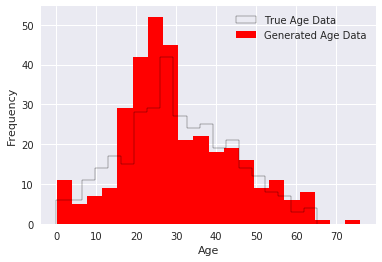

In [48]:
# First, determine how the Age data is distributed.
x_age = x_test['Age'].dropna().tolist()
mu_age = np.mean(x_age)
sigma_age = np.std(x_age)

# Generate age samples using the age data's
# average and standard deviation. Graphically
# compare the real and fabricated data (normalized
# for easy comparison).
x_age_generated = np.random.normal(mu_age, sigma_age, len(x_age))

# Set all ages below zero to zero.
x_age_generated[(x_age_generated <= 0)] = 0
plt.hist(x_age, bins=20, color='red', normed=0)
plt.hist(x_age_generated, bins=20, histtype='step', color='black', normed=0)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend(("True Age Data", "Generated Age Data"))
plt.show()

### Visually, the data distributions appear only mildly resemblant. Directly test whether the age data is normal by testing the similarity between the true and fabricated data distributions.

In [49]:
# Test whether these data sets have similar
# distributions using the Kolmogorov-Smirnov
# test. A large p-value (e.g. > 0.05) indicates
# that the distributions are similar enough to
# warrant considering them the same.
stats.ks_2samp(x_age, x_age_generated)

Ks_2sampResult(statistic=0.099397590361445798, pvalue=0.07045426846592423)

### For some randomized tests, the Klmogorov-Smirnov test tends to indicate that the age data is not normally distributed; it could "go either way".

In [50]:
# Contrary to the above K-S test, as an approximation, assume
# the age data is normally distributed and replace all NaN
# values with values randomly selected from a normal
# distribution with the same mean and standard deviation
# as the non-NaN value data.
replace_with_normal(x_test, 'Age', MAGIC_SEED)

# Set all ages below zero to zero (a consequence of choosing
# ages from a normal distribution).
x_test.loc[x_test['Age'] < 0, 'Age'] = 0.0

# Replace the single NaN Fare to the median value.
x_test.loc[:,'Fare'] = preprocessing.Imputer(strategy='median').fit_transform(df['Fare'].values.reshape(-1,1))

In [51]:
# Since the 'Cabin' feature is very sparse and since
# it was dropped in the training data), drop this feature.
print("Out of %d instances, %d have missing Cabin information; dropping this feature."
      % (df.shape[0], sum(x_test['Cabin'].isna())))
x_test.drop('Cabin', axis='columns', inplace=True)

Out of 418 instances, 327 have missing Cabin information; dropping this feature.


In [52]:
# It seems unlikely that the passenger's name,
# ticket number, or port of embarkation would
# correlate with their survival. These features
# were dropped in the training data, so drop them
# here, as well.
x_test.drop('Name', axis='columns', inplace=True)
x_test.drop('Ticket', axis='columns', inplace=True)
x_test.drop('Embarked', axis='columns', inplace=True)

In [53]:
# Retrieve the categorical column labels.
categorical_features = x_test.select_dtypes(include=['object']).columns.tolist()

# Encode all categorical features.
encoded_label_groups = encode(x_test)
features_and_encoded_labels = list(zip(categorical_features, encoded_label_groups))

In [54]:
# At this point, the DataFrame should be free of
# missing values.
nan_int_cols = gather_nan(x_test, "int")
nan_float_cols = gather_nan(x_test, "float")
nan_string_cols = gather_nan(x_test, "string")
x_test.head()


0 int-type columns with NaN values.

0 float-type columns with NaN values.

0 string-type columns with NaN values.


,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
892,3,1,34.5,0,0,7.8292
893,3,0,47.0,1,0,7.0000
894,2,1,62.0,0,0,9.6875
895,3,1,27.0,0,0,8.6625
896,3,0,22.0,1,1,12.2875


# Use prediction_model to predict y_test.

In [55]:
# Generate the predicted house prices.
y_test_pred = prediction_model.predict(x_test)

# Convert y_test_pred to a DataFrame
# with indices and a column label consistent
# with the submission criteria as demonstrated
# in the sample submission .csv file.
y_test_pred_df = pd.DataFrame(y_test_pred, index=x_test.index, columns=['Survived'])

# Ensure the DataFrame appears to be
# properly arranged.
y_test_pred_df.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [56]:
# Write the DataFrame to a .csv file.
if (save_predicted_data):
    y_test_pred_df.to_csv(MY_PREDICTED_DATA_PATH)